# Feature extraction using 1/3 octave filters


## 1. Preparing a csv-file


In [51]:
import csv 

user_mode = False

In [52]:
if user_mode == 'y':
    csv_name = input("give your csv-file a name: ") + '.csv'
else:
    csv_name = "th_oct_feature.csv"

n_th_octvs = 31
n_classes = 10
header = 'fn class'
for i in range(1, n_th_octvs):
    header += f' th_octv{i}'
header = header.split()

csv_fp = 'Datasets/Feature_extraction/' + csv_name
csv_file = open(csv_fp, 'w', newline='')
with csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(header)

## 2. Core parameters

In [53]:
fs = 48000
fmin = 20
fmax = 20000
oct_bw_ratio = 1/3  # octave / amount of subdivisions
order = 6
dec_iir_order = 8

n_coeffs_p_section = 6
n_sections = order / 2

# window_size = 6000 # corresponds to 125 ms
window_size = 48000


padded_sample_sec = fs + 128
max_dur = 5
start_frame = 0
non_zero_c = 1e-20

std_csv_fp = "Datasets/Feature_extraction/th_oct_coeffs.csv"
std_scaling_fp = "Datasets/Feature_extraction/scalings.csv"
test_wav = "demo_data/sine60.wav"

## 3. Filter exploaration
[PyOctaveBand](https://github.com/jmrplens/PyOctaveBand)

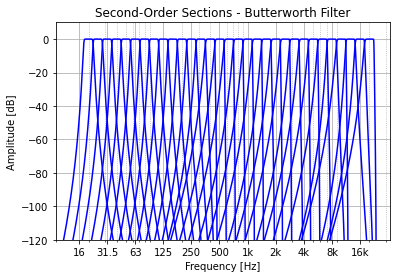

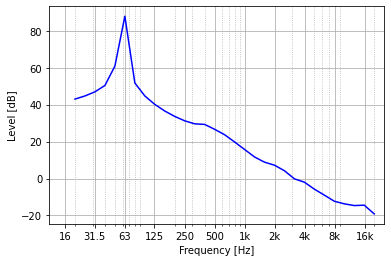


center frequencies:
[19.952623149688794, 25.118864315095813, 31.6227766016838, 39.81071705534973, 50.118723362727245, 63.09573444801933, 79.43282347242817, 100.0, 125.89254117941672, 158.48931924611136, 199.526231496888, 251.188643150958, 316.22776601683796, 398.1071705534973, 501.18723362727235, 630.9573444801932, 794.3282347242815, 1000.0, 1258.9254117941673, 1584.8931924611134, 1995.2623149688795, 2511.88643150958, 3162.277660168379, 3981.0717055349724, 5011.872336272723, 6309.573444801931, 7943.282347242814, 10000.0, 12589.25411794167, 15848.931924611134, 19952.623149688785]

spl-bins:
[19.952623149688794, 25.118864315095813, 31.6227766016838, 39.81071705534973, 50.118723362727245, 63.09573444801933, 79.43282347242817, 100.0, 125.89254117941672, 158.48931924611136, 199.526231496888, 251.188643150958, 316.22776601683796, 398.1071705534973, 501.18723362727235, 630.9573444801932, 794.3282347242815, 1000.0, 1258.9254117941673, 1584.8931924611134, 1995.2623149688795, 2511.88643150958, 

In [54]:
import PyOctaveBand.PyOctaveBand as pob
import librosa as lr
import octafilt3r.filter as o3

wav, sr = lr.load(test_wav, sr=fs, duration=max_dur)
spl_test, fcs_test = pob.octavefilter(wav, fs, 1/oct_bw_ratio, order, [fmin, fmax], show=1)
o3.plot_bode(fcs_test, spl_test)
print(f'\ncenter frequencies:\n{fcs_test}')
print(f'\nspl-bins:\n{fcs_test}')

>The filterbank by [Jose M. Requena Plens](https://github.com/jmrplens/PyOctaveBand) acts as a one-shot filterbank and will process a dynamic input size. Therefore it is necessary to wrap it into a window-regulating function which then produces a framerate of spectra. It is basically a low resolution, low fps STFT.

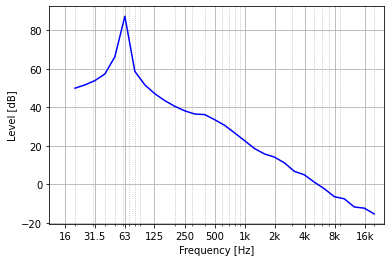

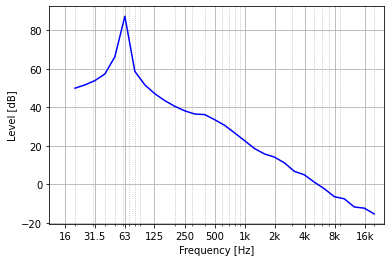

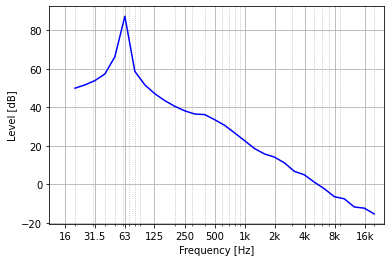

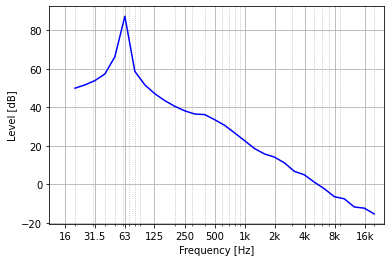

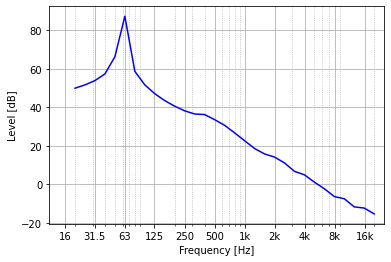

In [55]:
import numpy as np
from scipy import signal as sg

def oct_bank(x, fs, ratio, f_order, lims, window_size):

    # aa_sos = sg.butter(dec_iir_order, (fmax + 0.1 * fmax) / fs / 2, output='sos')
    # x = sg.sosfilt(aa_sos, x)

    # padding to get all files to a multiple of window-size:
    if int(len(x) / window_size) * window_size < len(x):
        pad = np.zeros(window_size - (len(x) % window_size))

    elif len(x) < window_size:
        pad = np.zeros(window_size - (len(x)))

    else:
        pad = []

    x_pad = np.append(x, pad)
    n_frames = int(len(x_pad)/window_size)

    fcs, fus, fls = pob._genfreqs(lims, 1/ratio, fs)
    oct_features = np.zeros((n_frames, len(fcs)))

    for frame in range(n_frames):
        frame_buf = x_pad[(frame * window_size):((frame + 1) * window_size)]
        spl, fcs = pob.octavefilter(frame_buf, fs, 1/ratio, f_order, lims)
        oct_features[frame] = spl

    return oct_features, fcs

feat, fcs = oct_bank(wav, fs, oct_bw_ratio, order, [fmin, fmax], window_size)

for spl in feat:
    #o3.plot_bins(fcs, spl)
    o3.plot_bode(fcs, spl)

## 4. Store features


In [56]:
import os
import pandas as pd

def archive_features(classes, main_dir, csv_name):
    for i in classes:
        for filename in os.listdir(f'{main_dir}{i}'):
            wav = f'{main_dir}{i}/{filename}'
            y, sr = lr.load(wav, mono=True, duration=max_dur)
        
            # feature extraction
            spl, fcs = pob.octavefilter()
        
            # writing feature data to csv file
            to_append = f'{filename} {np.mean(chroma_stft)} {np.mean(rms)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'    
            for e in mfcc:
                to_append += f' {np.mean(e)}'
            to_append += f' {i}'
            file = open(csv_name, 'a', newline='')
            with file:
                writer = csv.writer(file)
                writer.writerow(to_append.split())
    return _y